# Comparison between ClimateTRACE and C40 inventories

This analysis compares city aggregated estimates from [climateTRACE](https://climatetrace.org/) to estimates [GPC](https://ghgprotocol.org/ghg-protocol-cities) compliant C40 city inventories downloaded from [here](https://www.c40knowledgehub.org/s/article/C40-cities-greenhouse-gas-emissions-interactive-dashboard?language=en_US).

I am not sure if the C40 inventories are high quality. Comparing to downscaled observations would not be a fair comparison. 

In [1]:
import json
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

sns.set(style="whitegrid")

In [2]:
from utils import (
    get_c40_data, 
    filter_out_notation_keys,
    climatetrace_file_names,
    load_climatetrace_file,
    point_to_lat_lon,
    lat_lon_to_locode_api
)

/Users/sherrywang/dev/ClimateTRACE_C40/env/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Read raw C40 data

**Units**: metric tonnes CO2-eq. (I am assuming these are units since they should be following the GPC)

In [3]:
df_c40_raw = get_c40_data()

### filter C40

In [4]:
refnos = ['II.4.3']
columns = ['city', 'locode', 'year'] + refnos

df_tmp = filter_out_notation_keys(df_c40_raw, refnos)
df_c40 = (
    df_tmp
    .loc[:, columns]
    .rename(columns = {'II.4.3': 'emissions_c40'})
)

### Read ClimateTRACE

**Units**: Units are tonnes 

In [5]:
asset_files = [
    './transportation/asset_international-aviation_emissions.csv',
    './transportation/asset_domestic-aviation_emissions.csv',
]
df_ct_raw = pd.concat([load_climatetrace_file(f) for f in asset_files], ignore_index=True)
filt = (df_ct_raw['gas'] == 'co2e_100yr') & (df_ct_raw['emissions_quantity'].notnull())
df_tmp = df_ct_raw.loc[filt]

In [6]:
points = set(df_tmp['st_astext'])
df_points = pd.DataFrame([point_to_lat_lon(point) for point in points])

df_merged = df_tmp.merge(df_points, on='st_astext')
df_unique = df_merged[['lon','lat']].drop_duplicates()
print(f"number unique assets: {len(df_unique)}")

number unique assets: 5073


In [7]:
climatetrace_locode_file = os.path.abspath("../data/processed/climatetrace_lat_lon_to_geocodes.csv")

if os.path.exists(climatetrace_locode_file):
    df_locodes_last = pd.read_csv(climatetrace_locode_file)
    df_unique = df_unique.merge(df_locodes_last, on=['lon','lat'], how='left', indicator=True)
    df_unique = df_unique[df_unique['_merge'] == 'left_only']

print(f"Unseen assets to be mapped to new locodes: {len(df_unique)}")
output_list = []
for _, row in tqdm(df_unique.head(100).iterrows()):
    lat = row['lat']
    lon = row['lon']
    locode = lat_lon_to_locode_api(lat, lon)
    output_list.append({'lon':lon, 'lat': lat, 'locode': locode})

if os.path.exists(climatetrace_locode_file):
    df_locodes = pd.concat([df_locodes_last, pd.DataFrame(output_list)], ignore_index=True)
    if len(output_list) > 0:
        df_locodes.to_csv(climatetrace_locode_file, index=False)
else:
    pd.DataFrame(output_list).to_csv(climatetrace_locode_file, index=False)

Unseen assets to be mapped to new locodes: 0


0it [00:00, ?it/s]


In [8]:
df_merged_locodes = df_merged.merge(df_locodes, on =['lat','lon'])
filt = df_merged_locodes['locode'].notnull()
df_data = df_merged_locodes[filt]

In [9]:
df_ct = (
    df_data
    .assign(year = lambda row: pd.to_datetime(row['start_time']).dt.year)
    .loc[:, ['locode', 'year', 'emissions_quantity', 'emissions_factor_units']]
    .rename(columns = {'emissions_quantity': 'emissions_ct'})
)

In [10]:
# check the units
set(df_ct['emissions_factor_units'])

{'tonnes_gas_per_tonnes_fuel'}

In [11]:
df_ct = df_ct.groupby(['locode', 'year']).sum()['emissions_ct'].reset_index()

### Comparison

In [12]:
df_int = pd.merge(df_ct, df_c40, on = ['year', 'locode'], how='inner')
df_int['diff'] = df_int['emissions_ct'] - df_int['emissions_c40']
df_int['percent_error'] = (df_int['diff'] / df_int['emissions_c40']) * 100

In [13]:
df_int.loc[df_int['diff'].notnull()]

,locode,year,emissions_ct,city,emissions_c40,diff,percent_error
0,BR RIO,2015,2.640174e+06,Rio de Janeiro,2933672.945316,-293498.678387,-10.004478
1,BR RIO,2016,2.516757e+06,Rio de Janeiro,2839557.660322,-322801.043419,-11.368005
2,BR RIO,2017,2.360675e+06,Rio de Janeiro,2670365.360836,-309690.434825,-11.597306
3,BR SSA,2015,5.987342e+05,Salvador,256624,342110.179541,133.311841
4,BR SSA,2016,4.914595e+05,Salvador,200798,290661.495893,144.753183
5,BR SSA,2017,4.832875e+05,Salvador,169646,313641.492314,184.879981
6,BR SSA,2018,5.122131e+05,Salvador,589547.063578,-77333.964254,-13.117522
7,CA MTR,2015,2.085974e+06,Montréal,575905.304312,1510068.214646,262.207728
8,CA MTR,2016,2.255107e+06,Montréal,599893,1655214.191316,275.918237
9,CA MTR,2017,2.510355e+06,Montréal,628613,1881741.943949,299.348239


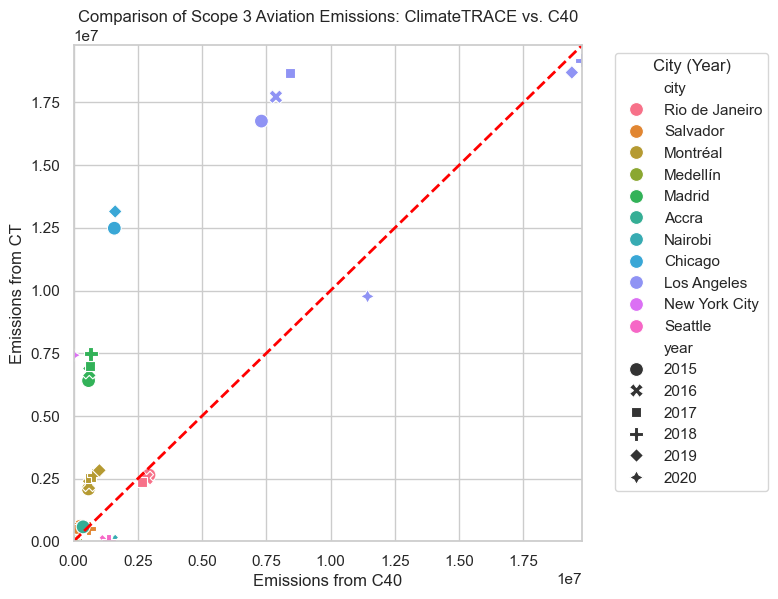

In [14]:
# Scatter plot
plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_int, x="emissions_c40", y="emissions_ct", hue="city", style="year", s=100)

max_value = max(df_int['emissions_ct'].max(), df_int['emissions_c40'].max())
plt.xlim(0, max_value)
plt.ylim(0, max_value)
plt.plot([0, max_value], [0, max_value], color="red", lw=2, linestyle='--')

plt.title('Comparison of Scope 3 Aviation Emissions: ClimateTRACE vs. C40')
plt.ylabel('Emissions from CT')
plt.xlabel('Emissions from C40')
plt.legend(title='City (Year)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

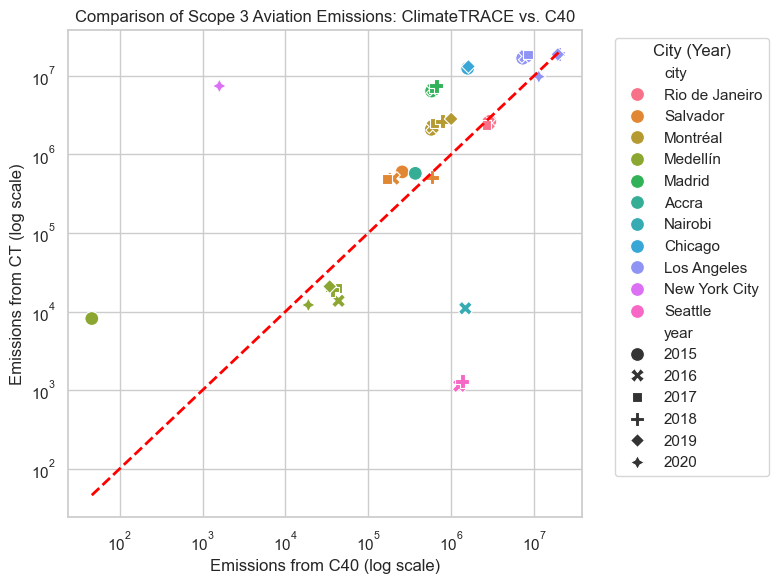

In [15]:
# Show scatterplot in log-long scale
plt.figure(figsize=(8, 6))

sns.scatterplot(data=df_int, x="emissions_c40", y="emissions_ct", hue="city", style="year", s=100)
plt.xscale('log')
plt.yscale('log')

plt.plot([df_int['emissions_c40'].min(), df_int['emissions_c40'].max()], 
         [df_int['emissions_c40'].min(), df_int['emissions_c40'].max()], 
         color="red", lw=2, linestyle='--')

plt.title('Comparison of Scope 3 Aviation Emissions: ClimateTRACE vs. C40')
plt.ylabel('Emissions from CT (log scale)')
plt.xlabel('Emissions from C40 (log scale)')
plt.legend(title='City (Year)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

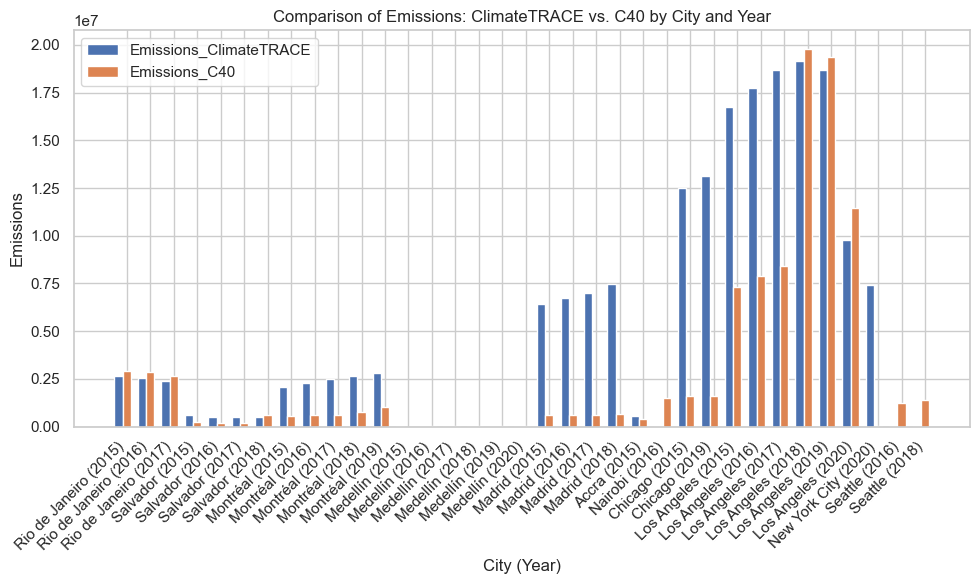

In [16]:
# Bar chart
plt.figure(figsize=(10, 6))

bar_data = df_int.set_index(['city', 'year'])
bar_width = 0.35
index = range(len(bar_data))

plt.bar(index, bar_data['emissions_ct'], bar_width, label='Emissions_ClimateTRACE')
plt.bar([i + bar_width for i in index], bar_data['emissions_c40'], bar_width, label='Emissions_C40')
plt.xlabel('City (Year)')
plt.ylabel('Emissions')
plt.title('Comparison of Emissions: ClimateTRACE vs. C40 by City and Year')
plt.xticks([r + bar_width for r in range(len(bar_data))], [f"{city} ({year})" for city, year in bar_data.index], rotation=45, ha="right")
plt.legend()

plt.tight_layout()
plt.show()